This is just a WIP script to visualized computed results.

In [3]:
# dependencies

from src.data_analysis.query_accuracy import query_accuracy, get_results_csv_path
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.spatial import ConvexHull
import glob
from copy import copy
import numpy as np
import pandas as pd
import cv2
from mpl_toolkits.axes_grid1 import ImageGrid


%matplotlib inline
plt.rcParams["figure.figsize"] = [14, 8]
plt.style.use("ggplot")

In [4]:
# show a face from each condition
def show_faces_of_condition(
    condition: str, suffixes: list, grid_size: tuple, figsize: tuple = (6, 8)
):
    potential_faces = glob.glob("Datasets//lfw//**//*.jpg", recursive=True)
    face_real_path = potential_faces[np.random.randint(len(potential_faces))]

    face_storage = []

    for suffix in suffixes:
        dataset_name = f"lfw_{condition}_{suffix}"
        current_path = face_real_path.replace(
            "Datasets//lfw", f"Anonymized Datasets//{dataset_name}"
        )

        try:
            face_img = cv2.imread(current_path)
            face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
            face_storage.append((face_img, suffix))
        except Exception as e:
            print(f"Warning: {suffix} not found, {e}.")

    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(
        fig,
        111,  # similar to subplot(111)
        nrows_ncols=grid_size,  # creates 2x2 grid of axes
        axes_pad=0.1,  # pad between axes in inch.
    )

    while len(face_storage) < grid_size[0] * grid_size[1]:
        face_storage.append((np.zeros_like(face_storage[0][0]), -1))

    for i, (ax, (im, suf)) in enumerate(zip(grid, face_storage)):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.text(10, 30, suf, color="b")
        ax.set_xticks([])
        ax.set_yticks([])

    grid[0].set_title(condition)
    plt.show()

In [5]:
def plot_results(
    fig,
    ax,
    mechanism: str,
    x_values: list,
    suffixes: list,
    xlabel_name: str = "",
    legend_name: str = "",
):
    assert len(suffixes) == len(x_values)

    is_empty = not ax[0, 0].lines

    # having to find the actual number of entries in CelebA's test set
    celeba_paths = glob.glob("Datasets//CelebA//**//*.jpg", recursive=True)
    rank_k_denominator = len(celeba_paths[182638:])

    zeros = [0 for _ in range(len(suffixes))]
    (
        rank_k_accs,
        rank_k5_accs,
        val_accs,
        val2_accs,
        ssim_accs,
        emotion_class_accs,
        emotion_prob_accs,
    ) = (
        copy(zeros),
        copy(zeros),
        copy(zeros),
        copy(zeros),
        copy(zeros),
        copy(zeros),
        copy(zeros),
    )

    for i in range(len(suffixes)):
        suf = suffixes[i]

        try:
            rank_k_accuracies = query_accuracy(
                "rank_k",
                dataset="CelebA",
                p_mech_suffix=f"{mechanism}_{suf}",
                mode="mean",
                denominator=rank_k_denominator,
            )
            rank_k_accs[i] = rank_k_accuracies["1"]
            rank_k5_accs[i] = rank_k_accuracies["50"]
        except Exception as e:
            print(f"No data for {mechanism}_{suf}, {e}.")

        try:
            val_acc = query_accuracy(
                "lfw_validation",
                dataset="lfw",
                p_mech_suffix=f"{mechanism}_{suf}",
                mode="mean",
                denominator=3000,
            )
            val_accs[i] = val_acc
        except Exception as e:
            print(f"No data for {mechanism}_{suf}, {e}.")

        try:
            val2_acc = query_accuracy(
                "validation",
                dataset="CelebA",
                p_mech_suffix=f"{mechanism}_{suf}",
                mode="mean",
                denominator=5000,
            )
            val2_accs[i] = val2_acc
        except Exception as e:
            print(f"No data for {mechanism}_{suf}, {e}.")

        try:
            util_acc = query_accuracy(
                "utility",
                dataset="CelebA",
                p_mech_suffix=f"{mechanism}_{suf}",
                mode="mean",
                denominator=rank_k_denominator,
            )
            ssim_accs[i] = util_acc["ssim_face"]
            emotion_class_accs[i] = util_acc["emotion_class"]
            emotion_prob_accs[i] = util_acc["emotion_prob_err"]
        except Exception as e:
            print(f"No data for {mechanism}_{suf}, {e}.")

    ax[0, 0].plot(x_values, rank_k_accs, label=legend_name, marker=".")
    ax[0, 1].plot(x_values, rank_k5_accs, label=legend_name, marker=".")
    ax[0, 2].plot(x_values, val_accs, label=legend_name, marker=".")
    ax[0, 3].plot(x_values, val2_accs, label=legend_name, marker=".")

    ax[1, 0].plot(x_values, ssim_accs, label=legend_name, marker=".")
    ax[1, 1].plot(x_values, emotion_class_accs, label=legend_name, marker=".")
    # random chance line
    if is_empty:
        ax[1, 1].plot(
            x_values,
            [1 / 7 for _ in range(len(x_values))],
            color="r",
            linestyle="--",
            alpha=0.5,
            label="random chance",
        )
    ax[1, 2].plot(x_values, emotion_prob_accs, label=legend_name, marker=".")

    fig.suptitle(mechanism)
    ax[0, 0].set_title("Rank K=1 on CelebA")
    ax[0, 1].set_title("Rank K=50 on CelebA")
    ax[0, 2].set_title("LFW Validation")
    ax[0, 3].set_title("Validation on CelebA")
    ax[1, 0].set_title("SSIM")
    ax[1, 1].set_title("Emotion Classification")
    ax[1, 2].set_title("Emotion Probability Error")
    ax[1, 3].set_title("TBD")

    for i in range(8):
        ii = i // 4
        jj = i % 4
        if min(x_values) < 1:
            ax[ii, jj].set_xscale("log")
        ax[ii, jj].set_xticks(
            x_values, [f"{z:.1f}" if z < 1 else f"{z:.0f}" for z in x_values]
        )
        ax[ii, jj].set_ylim([0, 1])
        ax[ii, jj].set_xlabel(xlabel_name)
        ax[ii, jj].legend()

In [16]:
def scatter_privacy_utility(
    mechanism: str,
    suffixes: list,
    color: tuple = (0, 0, 0),
    legend_name: str = "",
):
    # having to find the actual number of entries in CelebA's test set
    celeba_paths = glob.glob("Datasets//CelebA//**//*.jpg", recursive=True)
    rank_k_denominator = len(celeba_paths[182638:])

    zeros = [0 for _ in range(len(suffixes))]
    (
        rank_k_accs,
        emotion_class_accs,
    ) = (
        copy(zeros),
        copy(zeros),
    )

    for i in range(len(suffixes)):
        suf = suffixes[i]

        try:
            rank_k_accuracies = query_accuracy(
                "rank_k",
                dataset="CelebA",
                p_mech_suffix=f"{mechanism}_{suf}",
                mode="mean",
                denominator=rank_k_denominator,
            )
            rank_k_accs[i] = rank_k_accuracies["1"]
        except Exception as e:
            print(f"No data for {mechanism}_{suf}, {e}.")

        try:
            util_acc = query_accuracy(
                "utility",
                dataset="CelebA",
                p_mech_suffix=f"{mechanism}_{suf}",
                mode="mean",
                denominator=rank_k_denominator,
            )
            emotion_class_accs[i] = util_acc["emotion_class"]
        except Exception as e:
            print(f"No data for {mechanism}_{suf}, {e}.")

    plt.scatter(
        rank_k_accs, emotion_class_accs, color=color, s=400, alpha=0.2, zorder=0
    )
    plt.scatter(rank_k_accs, emotion_class_accs, label=legend_name, color=color)

    plt.title("Rank K vs Emotion Classification")
    plt.xlabel("Rank K ID-rate")
    plt.xticks([0, 0.5, 1], ["0%", "50%", "100%"])
    plt.ylabel("Emotion Classification Accuracy")
    plt.yticks([0, 0.5, 1], ["0%", "50%", "100%"])
    plt.legend()

Analyzing individual sessions:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


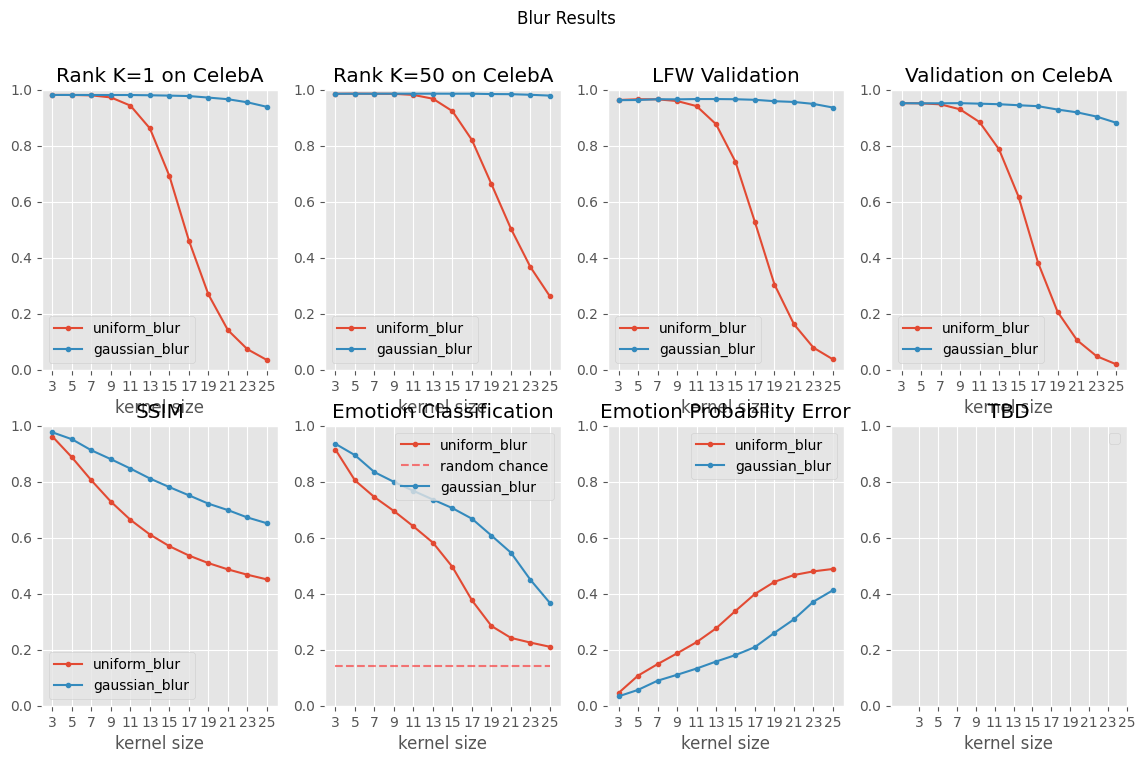

In [7]:
# looking at blurring results, comparing rank k on CelebA to lfw validation
fig, ax = plt.subplots(2, 4)
blur_kernels = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]
mechanisms = ["uniform_blur", "gaussian_blur"]

for mechanism in mechanisms:
    plot_results(
        fig,
        ax,
        mechanism,
        x_values=blur_kernels,
        suffixes=blur_kernels,
        xlabel_name="kernel size",
        legend_name=mechanism,
    )
fig.suptitle("Blur Results")
plt.show()

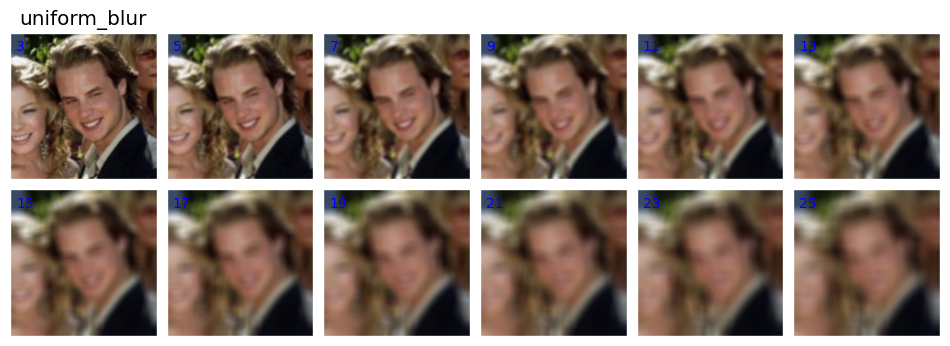

In [8]:
show_faces_of_condition(
    "uniform_blur", [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25], (2, 6), (12.0, 12.0)
)

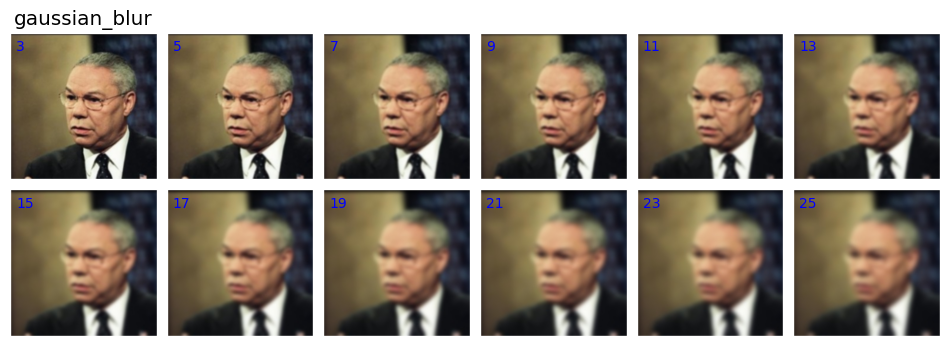

In [9]:
show_faces_of_condition(
    "gaussian_blur", [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25], (2, 6), (12.0, 12.0)
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


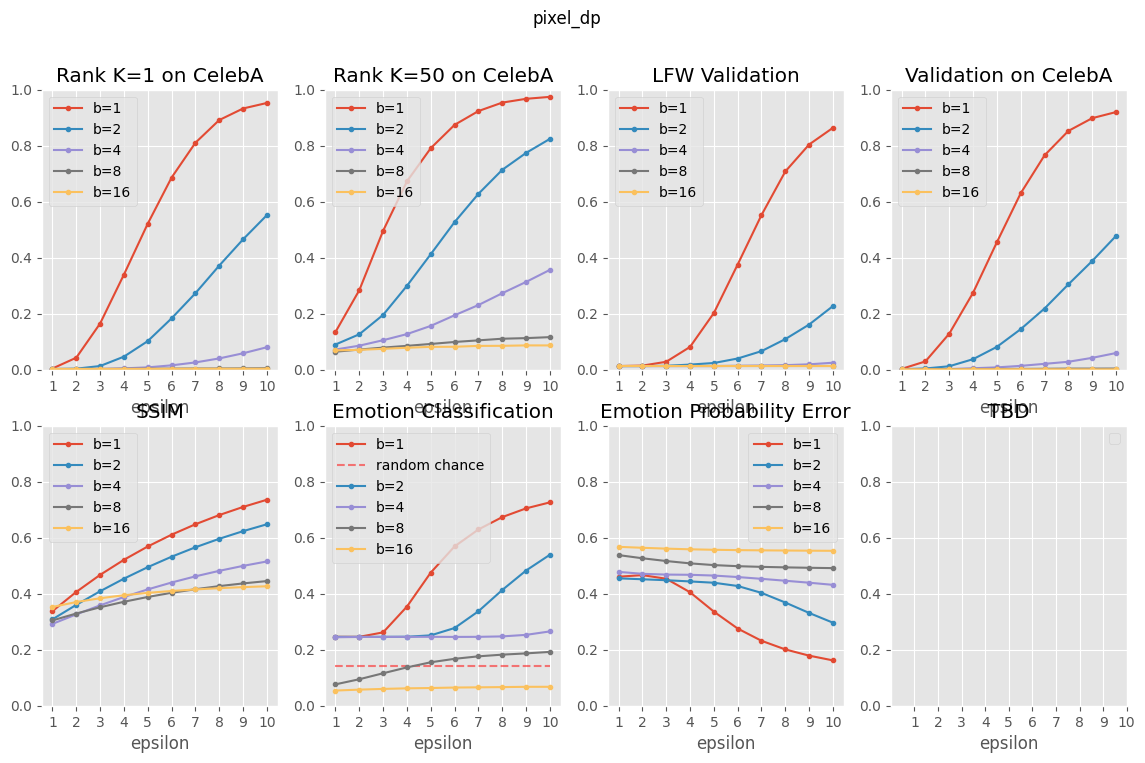

In [10]:
# look at pixel dp
fig, ax = plt.subplots(2, 4)

mechanism = "pixel_dp"
dp_epsilons = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
bs = [1, 2, 4, 8, 16]
for b in bs:
    suffixes = []
    for dp_eps in dp_epsilons:
        suffixes.append(f"{dp_eps}_b{b}")
    plot_results(
        fig,
        ax,
        mechanism,
        x_values=dp_epsilons,
        suffixes=suffixes,
        xlabel_name="epsilon",
        legend_name=f"b={b}",
    )
plt.show()

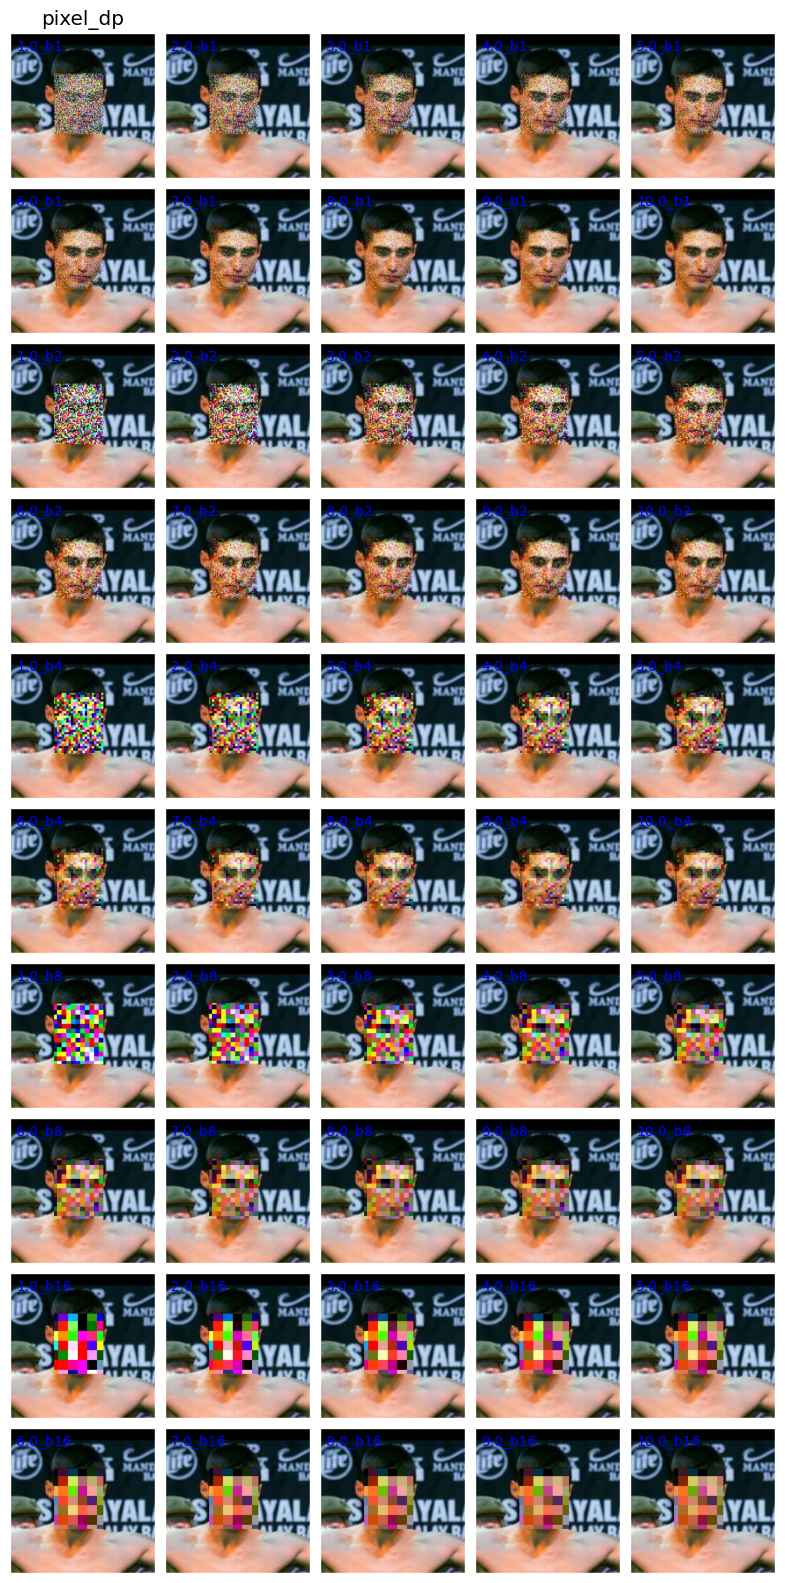

In [11]:
sufs_all = []
for b in [1, 2, 4, 8, 16]:
    sufs = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
    for i in range(len(sufs)):
        sufs_all.append(f"{sufs[i]}_b{b}")


show_faces_of_condition(
    "pixel_dp",
    sufs_all,
    (10, 5),
    (10.0, 20.0),
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


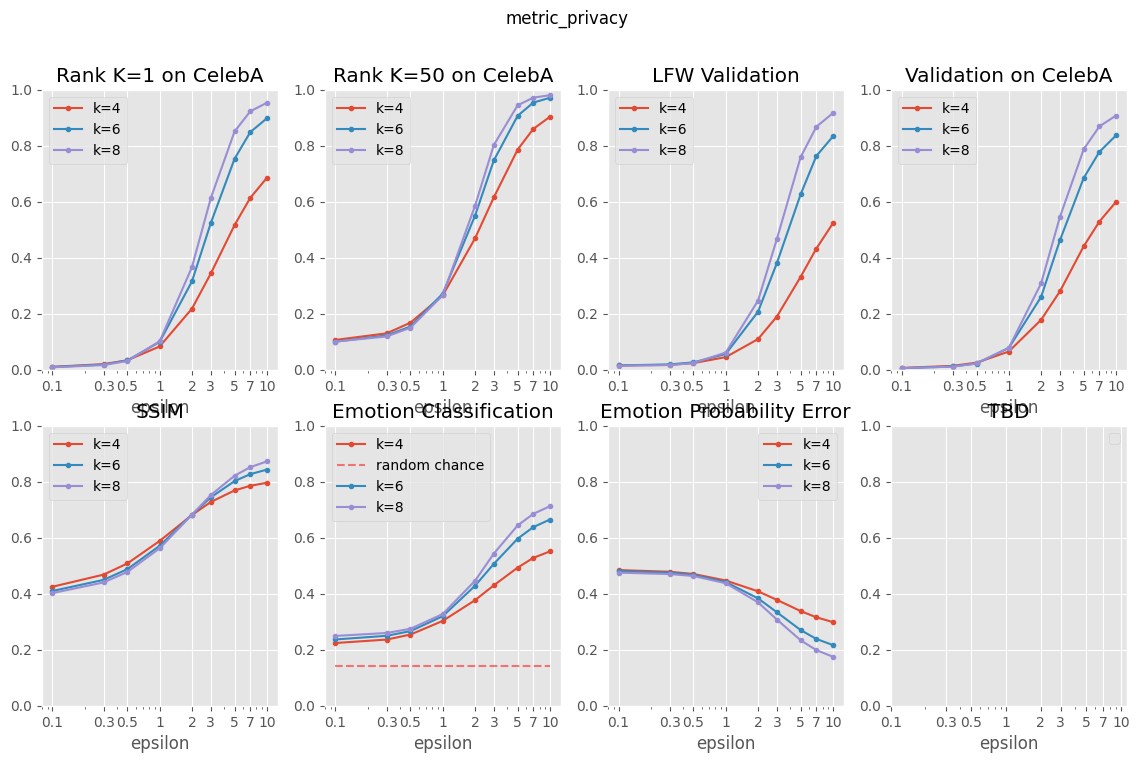

In [12]:
# metric privacy method
fig, ax = plt.subplots(2, 4)

mechanism = "metric_privacy"
dp_epsilons = [0.1, 0.3, 0.5, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0]
ks = [4, 6, 8]
for k in ks:
    suffixes = []
    for dp_eps in dp_epsilons:
        suffixes.append(f"{dp_eps}_k{k}")
    plot_results(
        fig,
        ax,
        mechanism,
        x_values=dp_epsilons,
        suffixes=suffixes,
        xlabel_name="epsilon",
        legend_name=f"k={k}",
    )
plt.show()

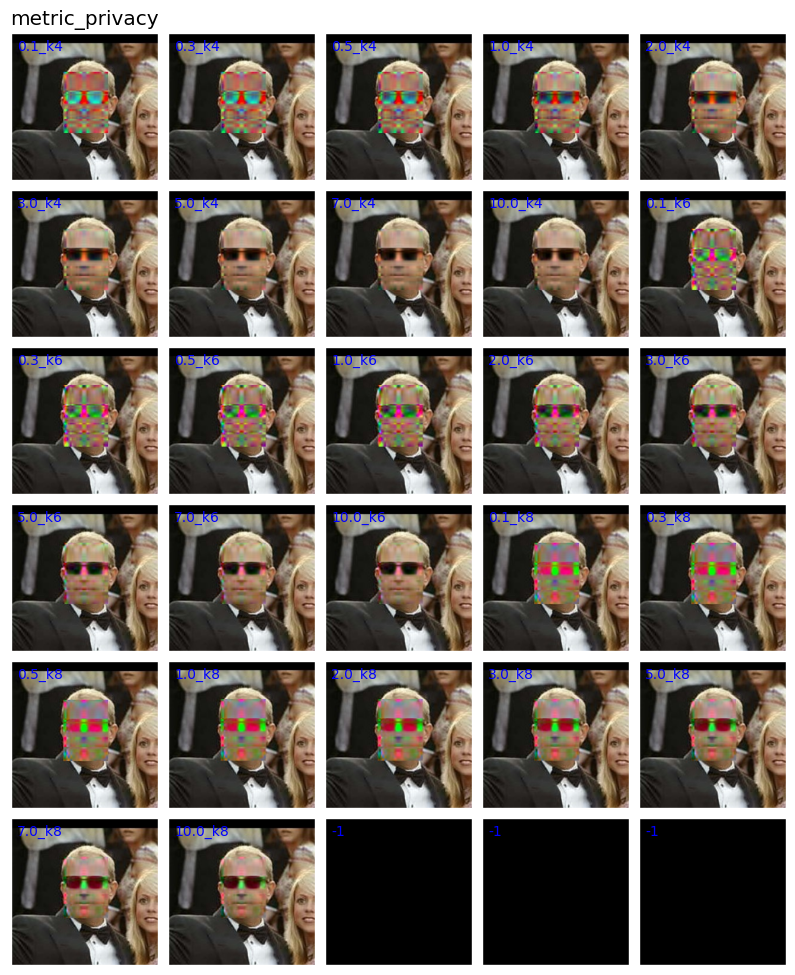

In [13]:
sufs_all = []
for k in [4, 6, 8]:
    sufs = [0.1, 0.3, 0.5, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0]
    for i in range(len(sufs)):
        sufs_all.append(f"{sufs[i]}_k{k}")


show_faces_of_condition(
    "metric_privacy",
    sufs_all,
    (6, 5),
    (10.0, 20.0),
)

Overlaying all mechanisms privacy-utility clusters:

<Figure size 1400x800 with 0 Axes>

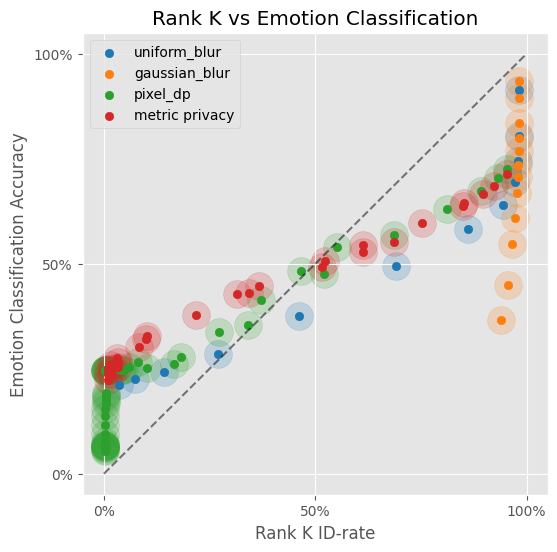

In [17]:
scatter_colors = list(mcolors.TABLEAU_COLORS.values())
# blur
plt.clf()
fig = plt.figure(figsize=(6, 6))

blur_kernels = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]
mechanisms = ["uniform_blur", "gaussian_blur"]

for i, mechanism in enumerate(mechanisms):
    scatter_privacy_utility(
        mechanism,
        suffixes=blur_kernels,
        color=scatter_colors[i],
        legend_name=mechanism,
    )

# pixelDP
sufs_all = []
for b in [1, 2, 4, 8, 16]:
    sufs = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
    for i in range(len(sufs)):
        sufs_all.append(f"{sufs[i]}_b{b}")
scatter_privacy_utility(
    "pixel_dp", suffixes=sufs_all, color=scatter_colors[2], legend_name="pixel_dp"
)

# metric privacy
sufs_all = []
for k in [4, 6, 8]:
    sufs = [0.1, 0.3, 0.5, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0]
    for i in range(len(sufs)):
        sufs_all.append(f"{sufs[i]}_k{k}")
scatter_privacy_utility(
    "metric_privacy",
    suffixes=sufs_all,
    color=scatter_colors[3],
    legend_name="metric privacy",
)

plt.plot([0, 1], [0, 1], color="k", linestyle="--", alpha=0.5)
plt.show()